# Kenali Sapinya
Anda memiliki 2 jenis gambar yaitu sapi tanpa background dan sapi dengan background.
Buatlah model pola sapi dengan gambar tanpa background. Kemudian gunakan pola tersebut untuk mendeteksi sapi dengan background. Gunakan interpolasi dan finite difference atau metode lain di dalam materi metode numerik.

Note:
1. Tidak boleh menggunakan library kecuali untuk membaca image
2. Algoritma Anda rancang sendiri dan implementasikan sendiri from scratch
3. Satu kelompok terdiri dari 4 orang.

In [2]:
import cv2
import matplotlib.pyplot as plt

## Menampilkan Gambar

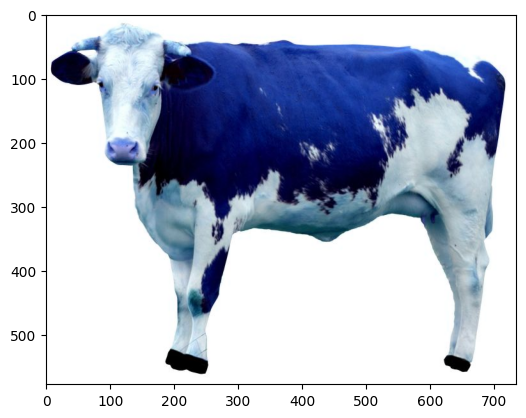

In [22]:
sapi_tanpa_bg1 = cv2.imread('./sapi1.jpg')
sapi_tanpa_bg2 = cv2.imread('./sapi2.jpeg')
sapi_tanpa_bg3 = cv2.imread('./sapi3.jpg')
sapi_dgn_bg = cv2.imread('./sapi_x.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(sapi_tanpa_bg1, cmap='gray')

In [23]:
def get_shape(image):
    height = len(image)
    width = len(image[0])
    return height, width

def resize_image(image, new_width, new_height):
    height, width = get_shape(image)

    scale_x = width / new_width
    scale_y = height / new_height

    resized_image = [[0] * new_width for _ in range(new_height)]

    for y in range(new_height):
        for x in range(new_width):
            src_x = int(x * scale_x)
            src_y = int(y * scale_y)

            x1 = src_x
            x2 = min(x1 + 1, width - 1)
            y1 = src_y
            y2 = min(y1 + 1, height - 1)

            weight_x = src_x - x1
            weight_y = src_y - y1

            top_left = image[y1][x1]
            top_right = image[y1][x2]
            bottom_left = image[y2][x1]
            bottom_right = image[y2][x2]

            interpolated_pixel = [
                int((1 - weight_x) * (1 - weight_y) * top_left[0] +
                    weight_x * (1 - weight_y) * top_right[0] +
                    (1 - weight_x) * weight_y * bottom_left[0] +
                    weight_x * weight_y * bottom_right[0]),
                int((1 - weight_x) * (1 - weight_y) * top_left[1] +
                    weight_x * (1 - weight_y) * top_right[1] +
                    (1 - weight_x) * weight_y * bottom_left[1] +
                    weight_x * weight_y * bottom_right[1]),
                int((1 - weight_x) * (1 - weight_y) * top_left[2] +
                    weight_x * (1 - weight_y) * top_right[2] +
                    (1 - weight_x) * weight_y * bottom_left[2] +
                    weight_x * weight_y * bottom_right[2])
            ]

            resized_image[y][x] = interpolated_pixel

    return resized_image

new_width = 200
new_height = 150

resized_image = resize_image(image, new_width, new_height)

## Deteksi Edge dengan Finite Difference

In [24]:
def get_shape(image):
    # assumes that array is symmetric
    return len(image), len(image[0])

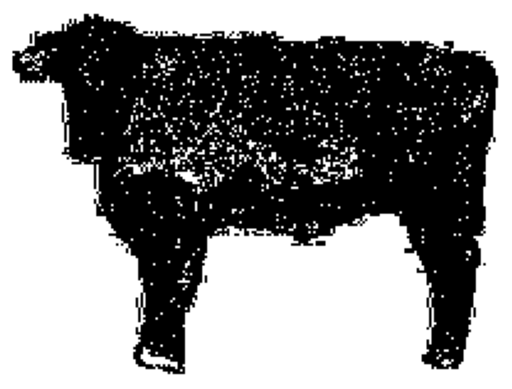

In [64]:
def calc_thresh(value, thresh):
    if value > thresh:
        return 0
    else:
        return 255

def calc_new_value(im, i, j, thresh):
    m, n = get_shape(im)
    h = 1

    if j == 0:
        a = im[i][j+1]  # Access the pixel value
        b = im[i][j+1]
        # forward
    elif j == n - 1:
        a = im[i][j-1]  # Access the pixel value
        b = im[i][j-1]
        # backward
    else:
        a = im[i][j+1]  # Access the pixel value
        b = im[i][j-1]
        h = 2

    return calc_thresh(abs(int(a[0]) - int(b[0])) / h, thresh)

def apply(im, low_thresh, high_thresh):
    new_im = [row[:] for row in im]
    for i in range(len(im)):
        for j in range(len(im[i])):
            value = calc_new_value(im, i, j, high_thresh)
            if value == 0:
                new_im[i][j] = 0
            elif value == 255:
                new_im[i][j] = calc_new_value(im, i, j, low_thresh)
    return new_im

def display_im(im):
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.show()

result = apply(resized_image, 0, 1)
display_im(result)


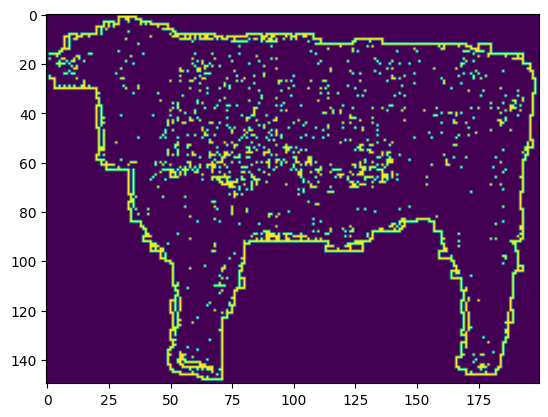

In [84]:
# 8-connectivity algorithm
def detect_edges(image):
    height, width = len(image), len(image[0])
    edges = [[0] * width for _ in range(height)]  # Initialize an empty edges image

    # Check the 8-connectivity of each pixel
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if image[i][j] == 255:  # Check if the pixel is filled
                if (
                    image[i - 1][j - 1] == 0
                    or image[i - 1][j] == 0
                    or image[i - 1][j + 1] == 0
                    or image[i][j - 1] == 0
                    or image[i][j + 1] == 0
                    or image[i + 1][j - 1] == 0
                    or image[i + 1][j] == 0
                    or image[i + 1][j + 1] == 0
                ):
                    edges[i][j] = 255  # Set the edge pixel to white

    return edges

detected_edges = detect_edges(result)
plt.imshow(detected_edges)

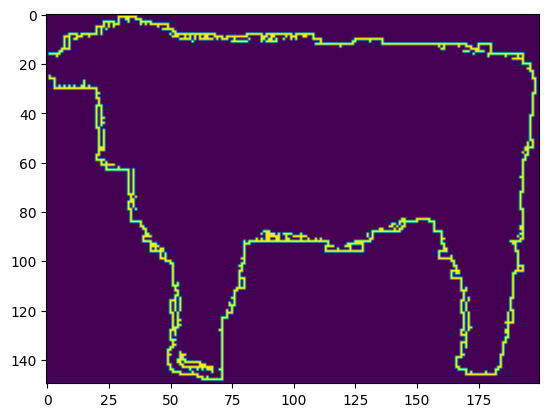

In [86]:
def connected_component_labeling(edges):
    height, width = len(edges), len(edges[0])
    visited = [[False] * width for _ in range(height)]
    components = []

    def dfs(i, j, component):
        if i < 0 or i >= height or j < 0 or j >= width:
            return
        if visited[i][j] or edges[i][j] != 255:
            return

        visited[i][j] = True
        component.append((i, j))

        # Explore the 8-connectivity neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                dfs(i + dx, j + dy, component)

    # Perform connected component labeling
    for i in range(height):
        for j in range(width):
            if not visited[i][j] and edges[i][j] == 255:
                component = []
                dfs(i, j, component)
                components.append(component)

    return components


def remove_disconnected_dots(edges, min_dot_size):
    components = connected_component_labeling(edges)

    # Remove small disconnected dots
    for component in components:
        if len(component) < min_dot_size:
            for i, j in component:
                edges[i][j] = 0

    return edges

plt.imshow(remove_disconnected_dots(detected_edges, 40))

# Convex Hull (Jarvis's March)

In [65]:
def graham_scan(points):
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0  # collinear
        elif val > 0:
            return 1  # clockwise
        else:
            return 2  # counterclockwise

    def dist_squared(p1, p2):
        return (p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2

    n = len(points)
    if n < 3:
        return []

    hull = []

    # Find the leftmost point
    leftmost = min(points, key=lambda p: p[0])

    p = 0
    q = 0
    while True:
        hull.append(points[p])
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p], points[i], points[q]) == 2:
                q = i
        p = q

        # Check if we have reached the first point
        if p == 0:
            break

    return hull


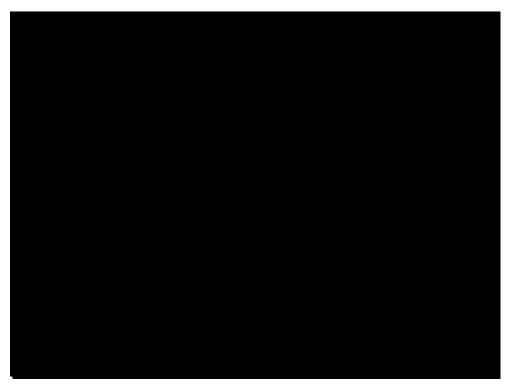

In [66]:
height, width = len(result), len(result[0])
edges = []
for y in range(height):
    for x in range(width):
        if result[y][x] == 255:
            edges.append((x, y))

hull = graham_scan(edges)

hull_image = [[0] * width for _ in range(height)]
for x, y in hull:
    hull_image[y][x] = 255

display_im(hull_image)

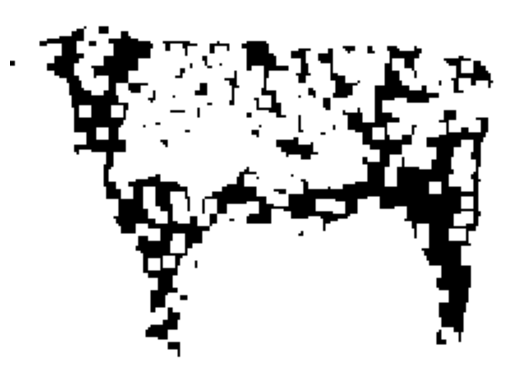

In [74]:
def perform_morphology(image):
    kernel = [[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]]

    height, width = get_shape(image)
    result = [[0] * width for _ in range(height)]

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if image[y][x] == 255:
                result[y][x] = 255

                for ky in range(-1, 2):
                    for kx in range(-1, 2):
                        if kernel[ky+1][kx+1] == 1:
                            result[y+ky][x+kx] = 255

    return result
result_2 = perform_morphology(result)
display_im(perform_morphology(result_2))


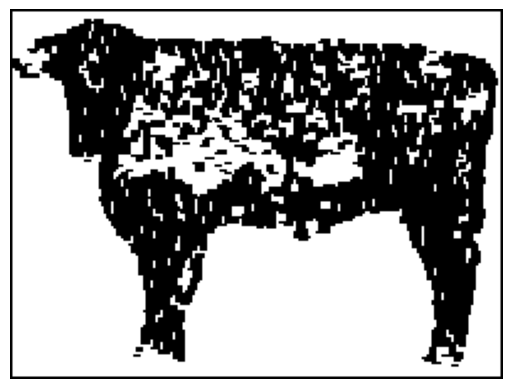

In [75]:
def perform_erosion(image):
    kernel = [[0, 0, 0],
              [1, 1, 1],
              [0, 0, 0]]

    height, width = get_shape(image)
    result = [[0] * width for _ in range(height)]

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if image[y][x] == 255:
                is_erosion = True

                for ky in range(-1, 2):
                    for kx in range(-1, 2):
                        if kernel[ky+1][kx+1] == 1 and image[y+ky][x+kx] == 0:
                            is_erosion = False
                            break

                    if not is_erosion:
                        break

                if is_erosion:
                    result[y][x] = 255

    return result

display_im(perform_erosion(result_2))

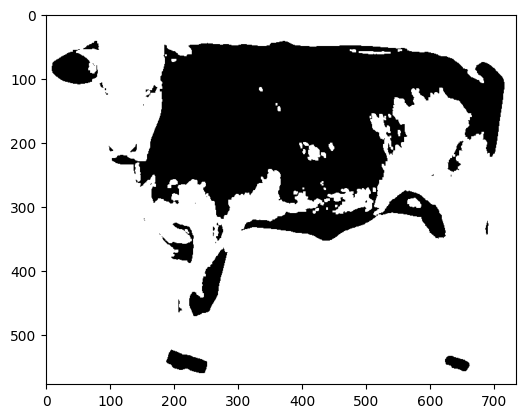

In [78]:
import cv2

def apply_threshold(image, threshold):
    height, width = get_shape(image)
    thresholded_image = [[0] * width for _ in range(height)]

    for y in range(height):
        for x in range(width):
            if image[y][x][0] >= threshold:
                thresholded_image[y][x] = 255
            else:
                thresholded_image[y][x] = 0

    return thresholded_image



def perform_morphology(image):
    kernel = [[1, 1, 1],
              [1, 1, 1],
              [1, 1, 1]]

    height, width = get_shape(image)
    result = [[0] * width for _ in range(height)]

    for y in range(1, height - 1):
        for x in range(1, width - 1):
            if image[y][x] == 255:
                result[y][x] = 255

                for ky in range(-1, 2):
                    for kx in range(-1, 2):
                        if kernel[ky+1][kx+1] == 1:
                            result[y+ky][   x+kx] = 255

    return result

def connected_component_analysis(image):
    height, width = get_shape(image)
    visited = [[False] * width for _ in range(height)]
    labels = [[0] * width for _ in range(height)]
    current_label = 1

    stack = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    for y in range(height):
        for x in range(width):
            if image[y][x] == 255 and not visited[y][x]:
                stack.append((x, y))

                while stack:
                    curr_x, curr_y = stack.pop()
                    visited[curr_y][curr_x] = True
                    labels[curr_y][curr_x] = current_label

                    for dx, dy in directions:
                        new_x, new_y = curr_x + dx, curr_y + dy

                        if (
                            0 <= new_x < width
                            and 0 <= new_y < height
                            and not visited[new_y][new_x]
                            and image[new_y][new_x] == 255
                        ):
                            stack.append((new_x, new_y))

                current_label += 1

    return labels, current_label - 1


def dfs(image, labels, visited, x, y, label):
    height, width = get_shape(image)

    if x < 0 or x >= width or y < 0 or y >= height:
        return

    if visited[y][x] or image[y][x] == 0:
        return

    visited[y][x] = True
    labels[y][x] = label

    dfs(image, labels, visited, x-1, y, label)
    dfs(image, labels, visited, x+1, y, label)
    dfs(image, labels, visited, x, y-1, label)
    dfs(image, labels, visited, x, y+1, label)

def generate_edge_image(labels, num_labels):
    height, width = get_shape(labels)
    edge_image = [[0] * width for _ in range(height)]

    for y in range(height):
        for x in range(width):
            if labels[y][x] > 0 and labels[y][x] < num_labels:
                edge_image[y][x] = 255

    return edge_image

# Load the grayscale image
# image = cv2.imread('path_to_your_image.jpg', cv2.IMREAD_GRAYSCALE)
image = sapi_tanpa_bg1
# Apply resizing with interpolation and obtain the edge image using finite difference

# Apply thresholding to obtain binary edge image
threshold = 90
thresholded_image = apply_threshold(image, threshold)

# Perform morphological operations for edge refinement
refined_image = perform_morphology(thresholded_image)

# Perform connected component analysis to identify object edges
labels, num_labels = connected_component_analysis(refined_image)

# Generate the final edge image
edge_image = generate_edge_image(labels, num_labels)

# Display the final edge image
plt.imshow(edge_image, cmap='gray')
plt.show()


